In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
cwd = os.getcwd()

api_path_toy = os.path.join(cwd, '..', 'tools', 'toy_examples_utils')
#api_path_sir = os.path.join(cwd, '..', 'tools', 'sir_ais_sampling')
models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'jensen_minimax')
#models_2d_path = os.path.join(cwd, '..', 'models_25gaussians', 'wasserstein')
sys.path.append(api_path_toy)
#sys.path.append(api_path_sir)
sys.path.append(os.path.join(cwd, '..', 'tools', 'sampling_utils'))

In [3]:
import numpy as np
import sklearn.datasets
import time
import random
import glob
import importlib
from tqdm import tqdm

import pyro
from pyro.infer import MCMC, NUTS, HMC
from functools import partial
import ot


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch, torch.nn as nn
import torch.nn.functional as F

from torch import autograd
from torch.distributions import MultivariateNormal, Normal, Independent, Uniform

from toy_examples_utils import (prepare_25gaussian_data, 
                   prepare_swissroll_data,
                   prepare_gaussians,
                   prepare_train_batches,
                   prepare_dataloader,
                   logging)
from gan_fc_models import (Generator_fc, 
                           Discriminator_fc, 
                           weights_init_1, 
                           weights_init_2)
from visualization import (send_file_to_remote,
                           sample_fake_data,
                           plot_fake_data_mode,
                           plot_fake_data_projection,
                           plot_discriminator_2d,
                           plot_potential_energy,
                           mh_sampling_plot_2d,
                           langevin_sampling_plot_2d,
                           mala_sampling_plot_2d,
                           #xtry_langevin_sampling_plot_2d,
                           epoch_visualization,
                           plot_chain_metrics)
from mh_sampling import mh_sampling
from ebm_sampling import (langevin_sampling, 
                          mala_sampling,
                          #xtry_langevin_sampling,
                          tempered_transitions_sampling,
                          gan_energy)

from sir_ais_sampling import sir_independent_dynamics
from ebm_sampling import mala_dynamics

from adaptive_mc import adaptive_sir_correlated_dynamics, ex2_mcmc_mala
from adaptive_sir_loss import *

from collections import defaultdict

from flows import RNVP


from distributions import (Target, 
                           Gaussian_mixture, 
                           IndependentNormal,
                           init_independent_normal, 
                           Funnel,
                          Banana, Cauchy,
                          Covtype_logistic_regression)

from params_25gaussians import (sigma,
                                random_seed,
                                train_dataset_size,
                                n_dim,
                                n_layers_d,
                                n_layers_g,
                                n_hid_d,
                                n_hid_g,
                                n_out,
                                device)

from general_utils import DotDict

from metrics import Evolution

In [4]:
from pathlib import Path
figpath = Path('../figs')

In [5]:

target_args = DotDict()
target_args.device = device
target_args.c1 = 3
target_args.c2 = 5
target = Covtype_logistic_regression(target_args)
n_dim = target.d

In [6]:
loc_proposal = torch.zeros(n_dim).to(device)
scale_proposal = torch.ones(n_dim).to(device)
proposal_args = DotDict()
proposal_args.device = device
proposal_args.loc = loc_proposal
proposal_args.scale = scale_proposal
proposal = IndependentNormal(proposal_args)

In [7]:
n_dim

54

In [8]:
args = edict()
args.batch_size = 20
args.device = device


In [9]:
def random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [10]:
def autocovariance(X, tau=0):
    #dT, dX = np.shape(X)
    dT = X.shape[0]
    s = 0.
    dN = 1
    if tau > 0:
        x1 = X[:-tau, ...]
    else:
        x1 = X
    x2 = X[tau:, ...]
    s = np.sum(x1 * x2, axis=0) / dN

    return s / (dT - tau)


def acl_spectrum(X, scale=1):
    n = 150 #X.shape[0]
    scale = np.sqrt(autocovariance(X, tau=0))
    return np.stack([autocovariance(X / (scale[None, ...] + 1e-7), tau=t) for t in range(n - 1)], axis=0)


def ESS(A):
    A = A * (A > 0.05)
    ess = 1. / (1. + 2 * np.sum(A[1:, ...], axis=0))
    return ess

In [11]:
# equal number of steps (1000)
n_steps = 100000
methods_calls = defaultdict(tuple)

method_args = edict()
method_args.n_steps = n_steps
method_args.N = 20
methods_calls['isir'] = partial(sir_independent_dynamics, **method_args)

method_args = edict()
method_args.n_steps = n_steps
method_args.grad_step = 1e-2
method_args.eps_scale = (2 * method_args.grad_step)**.5
method_args.adapt_stepsize = True
methods_calls['mala'] = partial(mala_dynamics, **method_args)

method_args = edict()
method_args.n_steps = n_steps
method_args.mala_steps = 1
method_args.grad_step = 1e-2
method_args.noise_scale = (2 * method_args.grad_step)**.5
method_args.N = 5
method_args.corr_coef = 0.9
method_args.bernoulli_prob_corr = 0.5
method_args.adapt_stepsize = True
methods_calls['ex2_mcmc_mala'] = partial(ex2_mcmc_mala, **method_args)

dim = n_dim
samples = []
names = []
# target = define_target(args.loc_1_target, args.loc_2_target, args.scale_target, dim, device=device)#.log_prob

for method_name, call in methods_calls.items():

    start = proposal.sample([args.batch_size])

    s = time.time()
    # hardcode
    if method_name == 'isir':
        out = call(start, target, proposal)
    else:
        out = call(start, target.log_prob, proposal)
    e = time.time()
    elapsed = (e - s) #/ 60
    if isinstance(out, tuple):
        sample = out[0]
    else:
        sample = out
    
    trunc_chain_len = int(0.9 * len(sample))

    ess_arr = []
    sample = torch.stack(sample, 0).detach().cpu().numpy()
    trunc_sample = sample[-trunc_chain_len:]
    batch_size = sample.shape[1]
    ess = ESS(acl_spectrum((trunc_sample - trunc_sample.mean(0)[None, ...]))).mean()
    print(f'Method: {method_name}, ESS: {ess:.4f}, sampling time: {elapsed:.2f}, ESS/s: {ess*n_steps/elapsed:.2f}')

    samples.append(trunc_sample)
    names.append(method_name)


  0%|          | 4/50000 [00:00<24:20, 34.23it/s]

Method: isir, ESS: 0.0074, sampling time: 6183.65, ESS/s: 0.06


  0%|          | 1/50000 [00:00<1:43:12,  8.07it/s]

Method: mala, ESS: 0.0048, sampling time: 1358.22, ESS/s: 0.18


100%|██████████| 50000/50000 [51:36<00:00, 16.15it/s]  


Method: ex2_mcmc_mala, ESS: 0.0040, sampling time: 3096.31, ESS/s: 0.07


In [28]:
batch_size_sample = 200
loss = "mix_kl" 
flow = RNVP(num_flows = 2, dim = n_dim )

In [29]:
params = flow.parameters()
optimizer = get_optimizer(params, optimizer = "Adam", lr = 3e-4, weight_decay=1e-3)

In [30]:
loss_function = get_loss(loss)

In [31]:
z_0 = proposal.sample((batch_size_sample,))
z_1, _ = flow(z_0)
z_1 = z_1.detach().numpy()
z_ = z_0.clone()


In [ ]:
N_optim = 2000
alpha = 0.
n_steps = 1
N = 5
grad_step = 2e-4
noise_scale = (2*grad_step)**.5
losses = []

for i in tqdm(range(N_optim)):
    zl, accept, grad_step = ex2_mcmc_mala(z_, target.log_prob,  proposal, n_steps, N, grad_step, (2*grad_step)**.5, 
                        mala_steps = 10, corr_coef=0., bernoulli_prob_corr=0.1, flow=flow,adapt_stepsize=True)
    #zl = adaptive_sir_correlated_dynamics(z_, true_target, proposal, n_steps, N, alpha, flow)
    #print(zl)
    z_ = zl[-1]
    #print(z_.shape)
    loss, grad_loss = loss_function(target.log_prob, proposal, flow, z_, alpha = min(1., 3*i/N_optim))
    losses.append(loss.detach().numpy())
    verbose = 10
    if i%verbose == 0:
        print("loss = ", np.mean(losses[-verbose:]))
        print("grad_step = ", grad_step)
        print("mean acceptance = ", accept.mean().numpy()*100,"%")

    (grad_loss).backward()
    optimizer.step()
    optimizer.zero_grad()

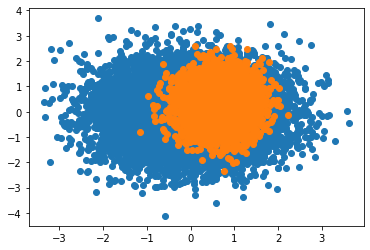

In [33]:
z_0 = proposal.sample((10000,))
z_1, _ = flow(z_0)
z_1 = z_1.detach().numpy()
i = 16
j = i+1
plt.scatter(z_0[:,i], z_0[:,j])
plt.scatter(z_1[:,i], z_1[:,j])


In [34]:
loss_function(target.log_prob, proposal, flow, z_, alpha = 1)

(tensor(-10450.3828, grad_fn=<AddBackward0>),
 tensor(83.8467, grad_fn=<AddBackward0>))

In [35]:
z_[torch.isnan(target.log_prob(z_))]


tensor([], size=(0, 54))

In [36]:
start = proposal.sample([args.batch_size])

s = time.time()
# hardcode

out = ex2_mcmc_mala(start, target.log_prob,  proposal, 50000, N, grad_step, (2*grad_step)**.5, 
                        mala_steps = 1, corr_coef=0., bernoulli_prob_corr=0.1, flow=flow,adapt_stepsize=True)
e = time.time()
elapsed = (e - s) #/ 60
if isinstance(out, tuple):
    sample = out[0]
else:
    sample = out

trunc_chain_len = int(0.1 * len(sample))

ess_arr = []
sample = torch.stack(sample, 0).detach().cpu().numpy()
trunc_sample = sample[-trunc_chain_len:]
batch_size = sample.shape[1]
ess = ESS(acl_spectrum((trunc_sample - trunc_sample.mean(0)[None, ...]))).mean()
print(f'Method: Ex2MC w Flows, ESS: {ess:.4f}, sampling time: {elapsed:.2f}, ESS/s: {ess*n_steps/elapsed:.2f}')

samples.append(trunc_sample)
names.append(method_name)


100%|██████████| 50000/50000 [37:22<00:00, 22.30it/s]


Method: Ex2MC w Flows, ESS: 0.0040, sampling time: 2242.21, ESS/s: 0.00


In [37]:
np.save('samples_theta_log_reg', samples)

In [38]:
from pyro.infer import MCMC, NUTS, HMC

def energy(z):
    z = z['points']
    return target.log_prob(z).sum()


#kernel = HMC(potential_fn=energy, step_size = 0.1, num_steps = K, full_mass = False)
kernel_true = NUTS(potential_fn=energy, full_mass = True)
init_samples = proposal.sample((2,))

init_params = {'points': init_samples}
mcmc_true = MCMC(kernel=kernel_true, num_samples = 200000,warmup_steps = 1000, initial_params=init_params)
mcmc_true.run()

q_true = mcmc_true.get_samples(group_by_chain=True)["points"].squeeze()
nuts_samples = np.array(q_true.view(-1, n_dim))

np.save('nuts_samples', nuts_samples)

Sample:   5%|▍         | 9198/201000 [8:55:52,  3.70s/it, step size=3.62e-06, acc. prob=0.755]

KeyboardInterrupt: 

Classification Error

In [74]:
def classification(theta, x, y):
    #pdb.set_trace()
    P = 1. / (1. + torch.exp(-torch.matmul(x,theta.transpose(0,1))))
    ll =  y[...,None]*torch.log(P) + (1-y[...,None])*(torch.log(1-P))
    return ll


In [75]:
i = np.random.randint(len(target.y_test))
i

5191

In [76]:

x_test = target.x_test[i] 
y_test = target.y_test[i]

In [77]:
samples[3].shape

(5000, 20, 54)

In [78]:
ll_post = []
idx= range(0, len(samples[0].reshape(-1, n_dim)), 100)
for i in range(len(samples)):
    test_samples = samples[i].reshape(-1, n_dim)[idx]
    ll_post.append(classification(torch.tensor(test_samples), target.x_test, target.y_test).exp().numpy())

In [79]:
for i in range(len(ll_post)):
    ll_post[i] = np.array(ll_post[i])

In [82]:
ll_post[0].shape

(7926, 1000)

In [104]:
i = np.random.randint(len(target.y_test))
ll_post_plot = [ll[i] for ll in ll_post]
i

2919

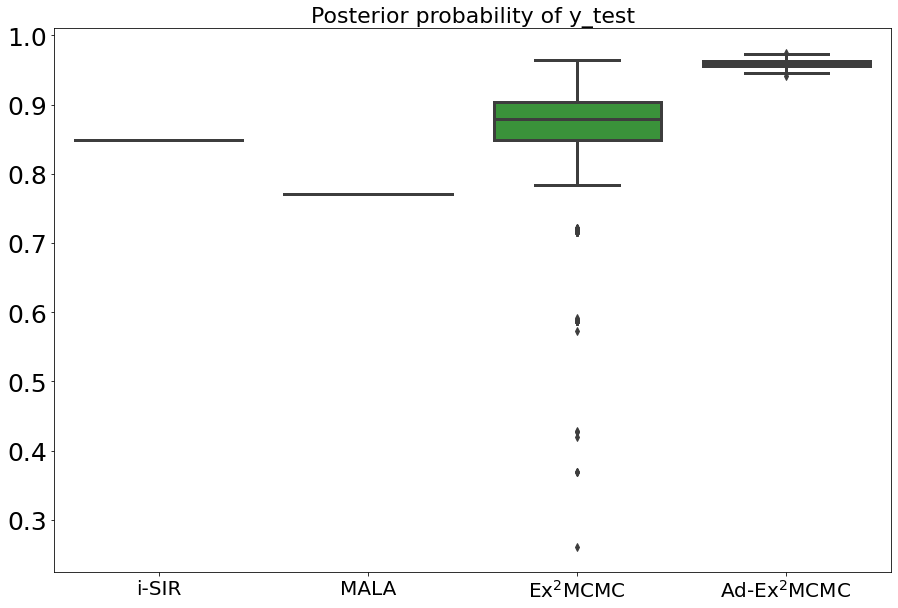

In [105]:
import seaborn as sns

plt.figure(figsize = (15, 10))
plt.rcParams.update({'font.size': 25})

#sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.boxplot(data = ll_post_plot, linewidth = 3)
#sns.swarmplot(data = total_res15, size = 6, color = 'black', alpha = 1.)
#plt.hlines(y = 12.5, xmin = -0.5, xmax=5.5, color = 'red')

plt.title('Posterior probability of y_test', fontsize = 22)
plt.xticks([0,1,2, 3 ],['i-SIR','MALA','Ex$^2$MCMC', 'Ad-Ex$^2$MCMC '],
           fontsize = 20 )
#plt.ylim(0,20)

plt.savefig(f"classification_true_label.pdf", bbox_inches = 'tight')